<h1 align="center">Classifying images from CIFAR100 using ResNet</h1>

### About dataset
The dataset is a collection of images of different objects separated in 20 folder as their classes.

### Content
The training dataset contains `50,000` and the test dataset contains `10,000` images of different objects. All the images have `3` channels (RGB) and the shape of the images are `32x32` pixels.

### Acknowledgements
- CIFAR100 dataset link - https://s3.amazonaws.com/fast-ai-imageclas/cifar100.tgz
- ResNet Implementation by pytorch - https://jovian.ai/learn/deep-learning-with-pytorch-zero-to-gans/lesson/lesson-5-data-augmentation-regularization-and-resnets


## Importing Libraries and create project

In [2]:
import os
import torch
import torchvision
import tarfile
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torch.utils.data import random_split
from torchvision.utils import make_grid
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

matplotlib.rcParams['figure.facecolor'] = '#ffffff'

In [3]:
project_name = "cifar100-resnet"

## Preparing the CIFAR100 Dataset

Downloading and extracting the datasets, also see the classes

In [5]:
from torchvision.datasets.utils import download_url

# Download dataset
dataset_url = "https://s3.amazonaws.com/fast-ai-imageclas/cifar100.tgz"
download_url(dataset_url, ".")

# Extract from archive
with tarfile.open("./cifar100.tgz", "r:gz") as tar:
  tar.extractall(path ="./data")

# Look into the data directory
data_dir = './data/cifar100'
print(os.listdir(data_dir))
classes = os.listdir(data_dir + "/test")
print(classes)

Using downloaded and verified file: ./cifar100.tgz
['test', 'train']
['large_carnivores', 'food_containers', 'insects', 'large_man-made_outdoor_things', 'household_furniture', 'reptiles', 'large_omnivores_and_herbivores', 'fish', 'small_mammals', 'aquatic_mammals', 'trees', 'people', 'medium_mammals', 'vehicles_1', 'vehicles_2', 'large_natural_outdoor_scenes', 'non-insect_invertebrates', 'household_electrical_devices', 'flowers', 'fruit_and_vegetables']


In [6]:
len(classes)

20

 Transforming data for the best and fast training output (Applying Normalization and Augmentation)

In [7]:
stats = ((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761))  # channelwise mean and std
train_tfms = tt.Compose([tt.RandomCrop(32, padding=4, padding_mode="reflect"),
                         tt.RandomHorizontalFlip(),
                         tt.ToTensor(),
                         tt.Normalize(*stats, inplace=True)
                         ])

valid_tfms = tt.Compose([tt.ToTensor(), tt.Normalize(*stats)])

In [8]:
# Pytorch datasets
train_ds = ImageFolder(data_dir+'/train', train_tfms)
valid_ds = ImageFolder(data_dir+'/test', valid_tfms)
len(train_ds), len(valid_ds)

(50000, 10000)

In [9]:
# Chechking the shape of the images
img, label = train_ds[0]
img.shape

torch.Size([3, 32, 32])

Now, we create data loaders for retriving images in batches. Here we will use a larger batch size to use the larger portion of the GPU RAM.

In [10]:
batch_size = 400

#Python data loaders
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)
valid_dl = DataLoader(valid_ds, batch_size*2, num_workers=3, pin_memory=True)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Let's see the images of a single batch from the training datsloader. For this we need to ***denormalize*** the pixels values to bring them back into the range `(0,1)`

In [11]:
def denormalize(images, means, stds):
  means = torch.tensor(means).reshape(1,3,1,1)
  stds = torch.tensor(stds).reshape(1,3,1,1)
  return images * stds + means

def show_batch(dl):
  for images, labels in dl:
    fig, ax = plt.subplots(figsize=(12, 12))
    ax.set_xticks([]); ax.set_yticks([])
    denorm_image = denormalize(images, *stats)
    ax.imshow(make_grid(denorm_image[:64], nrow=8).permute(1,2,0).clamp(0,1))
    break

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


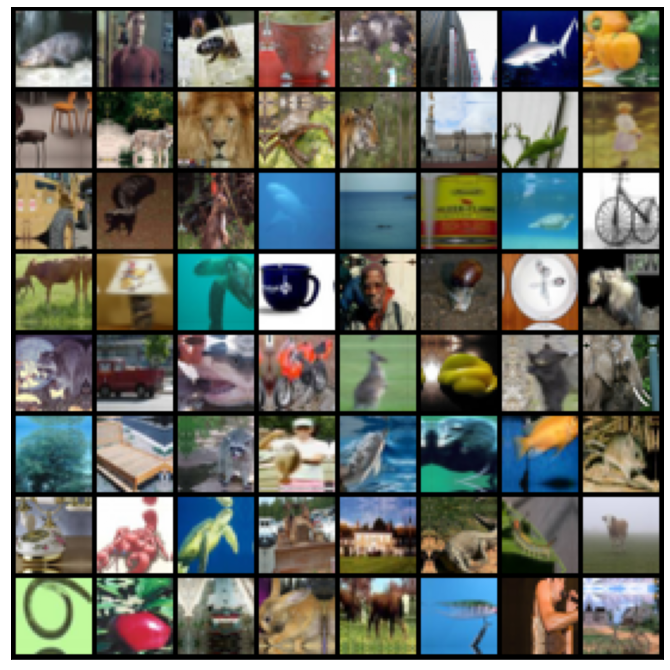

In [12]:
show_batch(train_dl)

## Using a GPU
To seamlessly use a GPU, if one is available, we define a couple of helper functions (`get_default_device` & `to_device`) and a helper class `DeviceDataLoader` to move our model & data to the GPU as required.

In [13]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

device = get_default_device()
device

device(type='cuda')

In [14]:
# Move data to the selected device
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

## Model with Residual Blocks and Batch Normalization

Base image classification model 

In [15]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))

ResNet9 model for image classification

In [16]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        # 3 x 32 x 32
        self.conv1 = conv_block(in_channels, 64)      # 64 x 32 x 32
        self.conv2 = conv_block(64, 128, pool=True)   # 128 x 16 x 16
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))  # 128 x 16 x16
        
        self.conv3 = conv_block(128, 256, pool=True)  # 256 x 8 x 8
        self.conv4 = conv_block(256, 512, pool=True)  # 512 x 4 x 4
        self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512)) # 512 x 4 x 4
        
        self.classifier = nn.Sequential(nn.MaxPool2d(4),    # 512 x 1 x 1
                                        nn.Flatten(),       # 512
                                        nn.Dropout(0.2),    # Drop 20% features to make it not overfit
                                        nn.Linear(512, num_classes))
        
    def forward(self, xb):
        out1 = self.conv1(xb)
        out2 = self.conv2(out1)
        out3 = self.res1(out2) + out2
        out4 = self.conv3(out3)
        out5 = self.conv4(out4)
        out6 = self.res2(out5) + out5
        out = self.classifier(out6)
        return out

In [17]:
model = to_device(ResNet9(3, 20), device)
model

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

## Training the model

In [18]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    
    # Set up cutom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [19]:
history = [evaluate(model, valid_dl)]
history

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[{'val_acc': 0.04788461700081825, 'val_loss': 2.9993956089019775}]

In [20]:
epochs = 17
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [ ]:
%%time
history += fit_one_cycle(epochs, max_lr, model, train_dl, valid_dl, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=opt_func)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [0], last_lr: 0.00127, train_loss: 2.4446, val_loss: 2.0257, val_acc: 0.3660
Epoch [1], last_lr: 0.00359, train_loss: 1.9684, val_loss: 1.8586, val_acc: 0.4229
Epoch [2], last_lr: 0.00650, train_loss: 1.7456, val_loss: 1.9104, val_acc: 0.4373
Epoch [3], last_lr: 0.00894, train_loss: 1.5570, val_loss: 2.1431, val_acc: 0.3990
Epoch [4], last_lr: 0.00999, train_loss: 1.3583, val_loss: 1.5471, val_acc: 0.5213
Epoch [5], last_lr: 0.00986, train_loss: 1.2041, val_loss: 1.4070, val_acc: 0.5651
Epoch [6], last_lr: 0.00938, train_loss: 1.1031, val_loss: 1.2332, val_acc: 0.6113
Epoch [7], last_lr: 0.00860, train_loss: 1.0260, val_loss: 1.2818, val_acc: 0.6112
Epoch [8], last_lr: 0.00758, train_loss: 0.9492, val_loss: 1.1407, val_acc: 0.6430
Epoch [9], last_lr: 0.00637, train_loss: 0.8681, val_loss: 1.0871, val_acc: 0.6657
Epoch [10], last_lr: 0.00507, train_loss: 0.7957, val_loss: 0.9782, val_acc: 0.6963
Epoch [11], last_lr: 0.00376, train_loss: 0.7089, val_loss: 0.8879, val_acc: 0.7236
Ep

In [ ]:
# Plot accuracy for epochs
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

# plot train and validation in a single plot
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

# Plot learning rate
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');

In [ ]:
plot_accuracies(history)

In [ ]:
plot_losses(history)

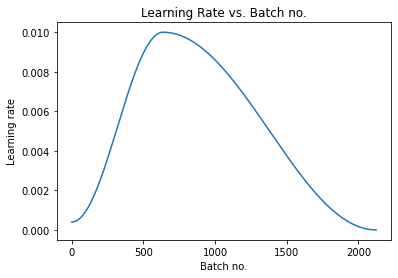

In [25]:
plot_lrs(history)

## Testing with individual images



In [26]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return train_ds.classes[preds[0].item()]

Label: aquatic_mammals , Predicted: aquatic_mammals


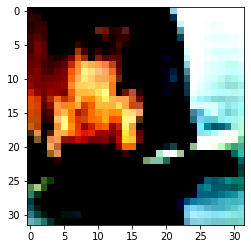

In [27]:
img, label = valid_ds[1]
plt.imshow(img.permute(1, 2, 0).clamp(0, 1))
print('Label:', train_ds.classes[label], ', Predicted:', predict_image(img, model))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: flowers , Predicted: flowers


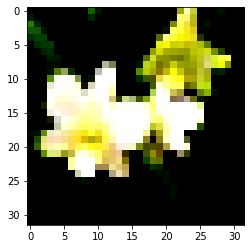

In [28]:
img, label = valid_ds[1002]
plt.imshow(img.permute(1, 2, 0))
print('Label:', valid_ds.classes[label], ', Predicted:', predict_image(img, model))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: household_furniture , Predicted: household_furniture


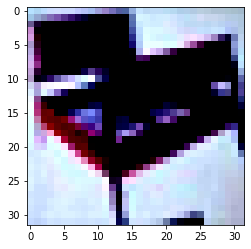

In [29]:
img, label = valid_ds[3010]
plt.imshow(img.permute(1, 2, 0))
print('Label:', valid_ds.classes[label], ', Predicted:', predict_image(img, model))

## Save and Commit

In [30]:
torch.save(model.state_dict(), "cifar100-resnet.pth")

## Conclusion and Further Work
- The model can now detect object from CIFAR100 Dataset.
- This is a project for the final assignment of Deep learning Course on Jovian
- It can further improved to classify all the 100 subclasses.
- This was my first attempt at a fully working project and I plan on expanding my knowledge in the field of image segmentation and obejct detection.